# Density Functional Theory (DFT): Foundations and Implementation

## Introduction

**Density Functional Theory (DFT)** is one of the most successful and widely used methods in computational quantum mechanics for investigating the electronic structure of many-body systems. Rather than solving the many-electron Schrödinger equation directly—an intractable problem for systems with more than a few electrons—DFT reformulates the problem in terms of the **electron density** $n(\mathbf{r})$, a function of only three spatial coordinates.

## Theoretical Background

### The Many-Body Problem

For a system of $N$ interacting electrons in an external potential $v_{\text{ext}}(\mathbf{r})$, the Hamiltonian is:

$$\hat{H} = \hat{T} + \hat{V}_{\text{ext}} + \hat{V}_{ee}$$

where:
- $\hat{T} = -\frac{\hbar^2}{2m}\sum_{i=1}^{N}\nabla_i^2$ is the kinetic energy operator
- $\hat{V}_{\text{ext}} = \sum_{i=1}^{N}v_{\text{ext}}(\mathbf{r}_i)$ is the external potential (typically nuclear attraction)
- $\hat{V}_{ee} = \frac{1}{2}\sum_{i\neq j}\frac{e^2}{|\mathbf{r}_i - \mathbf{r}_j|}$ is the electron-electron interaction

The many-body wavefunction $\Psi(\mathbf{r}_1, \mathbf{r}_2, ..., \mathbf{r}_N)$ depends on $3N$ coordinates, making direct solution computationally prohibitive.

### Hohenberg-Kohn Theorems

The foundation of DFT rests on two theorems proven by Hohenberg and Kohn (1964):

**Theorem 1:** The external potential $v_{\text{ext}}(\mathbf{r})$ is uniquely determined (up to a constant) by the ground-state electron density $n_0(\mathbf{r})$.

**Theorem 2:** There exists a universal functional $F[n]$ such that the ground-state energy can be obtained by minimizing:

$$E[n] = F[n] + \int v_{\text{ext}}(\mathbf{r}) n(\mathbf{r}) d\mathbf{r}$$

where the minimum is achieved at the true ground-state density $n_0(\mathbf{r})$.

The universal functional is:

$$F[n] = T[n] + E_{ee}[n]$$

### Kohn-Sham Formulation

Kohn and Sham (1965) introduced an ingenious approach: map the interacting system to a **fictitious non-interacting system** with the same ground-state density. The Kohn-Sham energy functional is:

$$E_{\text{KS}}[n] = T_s[n] + \int v_{\text{ext}}(\mathbf{r}) n(\mathbf{r}) d\mathbf{r} + E_H[n] + E_{xc}[n]$$

where:
- $T_s[n]$ is the kinetic energy of the non-interacting system
- $E_H[n] = \frac{1}{2}\int\int \frac{n(\mathbf{r})n(\mathbf{r}')}{|\mathbf{r}-\mathbf{r}'|} d\mathbf{r} d\mathbf{r}'$ is the Hartree (classical electrostatic) energy
- $E_{xc}[n]$ is the **exchange-correlation functional**, containing all quantum many-body effects

The Kohn-Sham equations are:

$$\left[-\frac{\hbar^2}{2m}\nabla^2 + v_{\text{eff}}(\mathbf{r})\right]\phi_i(\mathbf{r}) = \varepsilon_i \phi_i(\mathbf{r})$$

where the effective potential is:

$$v_{\text{eff}}(\mathbf{r}) = v_{\text{ext}}(\mathbf{r}) + v_H(\mathbf{r}) + v_{xc}(\mathbf{r})$$

with $v_H(\mathbf{r}) = \int \frac{n(\mathbf{r}')}{|\mathbf{r}-\mathbf{r}'|} d\mathbf{r}'$ and $v_{xc}(\mathbf{r}) = \frac{\delta E_{xc}[n]}{\delta n(\mathbf{r})}$.

The density is reconstructed from the occupied orbitals:

$$n(\mathbf{r}) = \sum_{i=1}^{N} |\phi_i(\mathbf{r})|^2$$

### Exchange-Correlation Approximations

The exact form of $E_{xc}[n]$ is unknown. Common approximations include:

**Local Density Approximation (LDA):**
$$E_{xc}^{\text{LDA}}[n] = \int n(\mathbf{r}) \varepsilon_{xc}(n(\mathbf{r})) d\mathbf{r}$$

where $\varepsilon_{xc}(n)$ is the exchange-correlation energy per particle of a homogeneous electron gas.

For exchange (Dirac):
$$\varepsilon_x(n) = -\frac{3}{4}\left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

## Numerical Implementation: 1D Kohn-Sham DFT

We will implement a simplified 1D Kohn-Sham DFT solver for electrons in an external potential. This pedagogical model captures the essential self-consistent field (SCF) procedure used in real DFT codes.

### Model System

We consider non-interacting electrons in a 1D harmonic potential, then add electron-electron interactions via the Hartree and exchange-correlation potentials. The 1D analogs are:

- **External potential:** $v_{\text{ext}}(x) = \frac{1}{2}\omega^2 x^2$
- **1D Hartree potential:** Solved from Poisson equation
- **1D LDA exchange:** $v_x(n) = -\left(\frac{3n}{\pi}\right)^{1/3}$ (adapted for 1D)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import simpson

# Physical constants (atomic units: hbar = m_e = e = 1)
# Grid parameters
N_grid = 500           # Number of grid points
x_max = 10.0           # Domain extent [-x_max, x_max]
x = np.linspace(-x_max, x_max, N_grid)
dx = x[1] - x[0]       # Grid spacing

# System parameters
N_electrons = 4        # Number of electrons (spin-paired)
omega = 1.0            # Harmonic oscillator frequency

print(f"Grid: {N_grid} points, dx = {dx:.4f} a.u.")
print(f"System: {N_electrons} electrons in harmonic potential (ω = {omega})")

Grid: 500 points, dx = 0.0401 a.u.
System: 4 electrons in harmonic potential (ω = 1.0)


In [2]:
def kinetic_matrix(N, dx):
    """
    Construct the kinetic energy matrix using finite differences.
    T = -1/2 * d²/dx² (in atomic units)
    Three-point stencil: d²f/dx² ≈ (f_{i+1} - 2f_i + f_{i-1}) / dx²
    """
    # Diagonal and off-diagonal elements
    diag = np.ones(N) / dx**2       # Main diagonal: 1/dx²
    off_diag = -0.5 * np.ones(N-1) / dx**2  # Off-diagonal: -1/(2*dx²)
    return diag, off_diag

def external_potential(x, omega):
    """Harmonic oscillator external potential: V_ext = 1/2 * ω² * x²"""
    return 0.5 * omega**2 * x**2

def hartree_potential(n, x, dx):
    """
    Compute the Hartree potential in 1D.
    In 1D, the Coulomb interaction is |x - x'|, so:
    V_H(x) = ∫ n(x') |x - x'| dx'
    
    We use a softened Coulomb interaction to avoid singularities:
    V_H(x) = ∫ n(x') / sqrt((x - x')² + ε²) dx'
    """
    epsilon = 0.5  # Softening parameter
    V_H = np.zeros_like(x)
    for i in range(len(x)):
        r = np.sqrt((x - x[i])**2 + epsilon**2)
        V_H[i] = simpson(n / r, x=x)
    return V_H

def exchange_potential_lda(n):
    """
    Local Density Approximation (LDA) exchange potential.
    In 3D: V_x = -(3n/π)^(1/3)
    Adapted for 1D with appropriate prefactor.
    """
    # Avoid division by zero
    n_safe = np.maximum(n, 1e-12)
    # 1D LDA exchange (simplified)
    return -0.5 * (3.0 * n_safe / np.pi)**(1.0/3.0)

def correlation_potential_lda(n):
    """
    Simplified LDA correlation potential.
    Using Perdew-Zunger parametrization (simplified).
    """
    n_safe = np.maximum(n, 1e-12)
    rs = (3.0 / (4.0 * np.pi * n_safe))**(1.0/3.0)  # Wigner-Seitz radius
    
    # Simplified correlation (small magnitude compared to exchange)
    # High density limit
    gamma = -0.1423
    beta1 = 1.0529
    beta2 = 0.3334
    
    v_c = np.where(
        rs < 1,
        gamma * np.log(rs) - 0.02,  # High density
        gamma / (1 + beta1 * np.sqrt(rs) + beta2 * rs)  # Low density
    )
    return v_c * 0.1  # Scale down for 1D

print("Potential functions defined.")

Potential functions defined.


In [3]:
def solve_kohn_sham(x, dx, V_eff, N_electrons):
    """
    Solve the Kohn-Sham equations:
    [-1/2 d²/dx² + V_eff(x)] φ_i(x) = ε_i φ_i(x)
    
    Returns eigenvalues and normalized wavefunctions.
    """
    N = len(x)
    
    # Kinetic energy (tridiagonal)
    T_diag, T_offdiag = kinetic_matrix(N, dx)
    
    # Full Hamiltonian diagonal: T + V_eff
    H_diag = T_diag + V_eff
    
    # Solve tridiagonal eigenvalue problem
    eigenvalues, eigenvectors = eigh_tridiagonal(H_diag, T_offdiag)
    
    # Normalize wavefunctions
    for i in range(eigenvectors.shape[1]):
        norm = np.sqrt(simpson(eigenvectors[:, i]**2, x=x))
        eigenvectors[:, i] /= norm
    
    return eigenvalues, eigenvectors

def compute_density(eigenvectors, N_electrons, x):
    """
    Compute electron density from occupied Kohn-Sham orbitals.
    n(x) = 2 * Σ_i |φ_i(x)|²  (factor of 2 for spin)
    """
    N_occupied = N_electrons // 2  # Number of doubly-occupied orbitals
    density = np.zeros_like(x)
    
    for i in range(N_occupied):
        density += 2.0 * eigenvectors[:, i]**2
    
    return density

def compute_total_energy(eigenvalues, n, V_H, V_xc, x, N_electrons):
    """
    Compute the total DFT energy.
    E_total = Σ_i ε_i - 1/2 ∫ n(x) V_H(x) dx - ∫ n(x) V_xc(x) dx + E_xc[n]
    
    The double-counting corrections account for:
    - Hartree energy counted twice in sum of eigenvalues
    - Need to replace V_xc contribution with E_xc
    """
    N_occupied = N_electrons // 2
    
    # Sum of occupied eigenvalues (with spin factor)
    E_eigenvalues = 2.0 * np.sum(eigenvalues[:N_occupied])
    
    # Double-counting correction for Hartree
    E_H_correction = -0.5 * simpson(n * V_H, x=x)
    
    # Exchange-correlation energy (LDA)
    n_safe = np.maximum(n, 1e-12)
    eps_x = -0.75 * (3.0 * n_safe / np.pi)**(1.0/3.0)  # Exchange energy density
    E_xc = simpson(n * eps_x, x=x)
    
    # XC potential contribution to subtract
    E_Vxc = -simpson(n * V_xc, x=x)
    
    E_total = E_eigenvalues + E_H_correction + E_xc + E_Vxc
    
    return E_total

print("Kohn-Sham solver functions defined.")

Kohn-Sham solver functions defined.


In [4]:
def scf_cycle(x, dx, N_electrons, omega, max_iter=100, tol=1e-6, mixing=0.3):
    """
    Self-Consistent Field (SCF) procedure for Kohn-Sham DFT.
    
    1. Start with initial guess for density
    2. Construct effective potential V_eff = V_ext + V_H + V_xc
    3. Solve KS equations → new orbitals
    4. Compute new density
    5. Mix densities and check convergence
    6. Repeat until self-consistent
    """
    print("Starting Self-Consistent Field (SCF) calculation...")
    print("="*60)
    
    # External potential
    V_ext = external_potential(x, omega)
    
    # Initial guess: Gaussian density
    n = N_electrons * np.exp(-x**2) / np.sqrt(np.pi)
    n = n * N_electrons / simpson(n, x=x)  # Normalize to N_electrons
    
    energies = []
    density_history = [n.copy()]
    
    for iteration in range(max_iter):
        # Construct effective potential
        V_H = hartree_potential(n, x, dx)
        V_x = exchange_potential_lda(n)
        V_c = correlation_potential_lda(n)
        V_xc = V_x + V_c
        V_eff = V_ext + V_H + V_xc
        
        # Solve Kohn-Sham equations
        eigenvalues, eigenvectors = solve_kohn_sham(x, dx, V_eff, N_electrons)
        
        # Compute new density
        n_new = compute_density(eigenvectors, N_electrons, x)
        
        # Compute total energy
        E_total = compute_total_energy(eigenvalues, n, V_H, V_xc, x, N_electrons)
        energies.append(E_total)
        
        # Check convergence (density difference)
        density_diff = np.sqrt(simpson((n_new - n)**2, x=x))
        
        if iteration % 10 == 0 or iteration < 5:
            print(f"Iter {iteration:3d}: E = {E_total:12.6f} a.u., "
                  f"Δn = {density_diff:.2e}")
        
        if density_diff < tol:
            print(f"\nConverged after {iteration + 1} iterations!")
            print(f"Final energy: {E_total:.8f} a.u.")
            break
        
        # Mix old and new densities (linear mixing for stability)
        n = (1 - mixing) * n + mixing * n_new
        density_history.append(n.copy())
    
    else:
        print(f"\nWarning: SCF did not converge after {max_iter} iterations")
    
    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'density': n,
        'V_ext': V_ext,
        'V_H': V_H,
        'V_xc': V_xc,
        'V_eff': V_eff,
        'energies': energies,
        'density_history': density_history
    }

# Run SCF calculation
results = scf_cycle(x, dx, N_electrons, omega, max_iter=100, tol=1e-7, mixing=0.3)

Starting Self-Consistent Field (SCF) calculation...


Iter   0: E =     6.938209 a.u., Δn = 2.40e+00


Iter   1: E =     8.420946 a.u., Δn = 1.21e+00


Iter   2: E =     8.786653 a.u., Δn = 6.01e-01


Iter   3: E =     8.871315 a.u., Δn = 3.21e-01


Iter   4: E =     8.892731 a.u., Δn = 1.81e-01


Iter  10: E =     8.897914 a.u., Δn = 1.06e-02


Iter  20: E =     8.897338 a.u., Δn = 1.61e-04


Iter  30: E =     8.897333 a.u., Δn = 3.10e-06


Iter  40: E =     8.897333 a.u., Δn = 7.17e-08

Converged after 41 iterations!
Final energy: 8.89733340 a.u.


In [5]:
# Analysis of results
print("\n" + "="*60)
print("KOHN-SHAM ORBITAL ANALYSIS")
print("="*60)

N_occupied = N_electrons // 2
print(f"\nOccupied orbitals: {N_occupied}")
print(f"Total electrons: {N_electrons}")

print("\nKohn-Sham eigenvalues (occupied):")
for i in range(N_occupied):
    print(f"  ε_{i+1} = {results['eigenvalues'][i]:10.6f} a.u.")

print("\nKohn-Sham eigenvalues (virtual, first 3):")
for i in range(N_occupied, min(N_occupied + 3, len(results['eigenvalues']))):
    print(f"  ε_{i+1} = {results['eigenvalues'][i]:10.6f} a.u.")

# HOMO-LUMO gap
homo = results['eigenvalues'][N_occupied - 1]
lumo = results['eigenvalues'][N_occupied]
gap = lumo - homo
print(f"\nHOMO-LUMO gap: {gap:.6f} a.u. ({gap * 27.211:.3f} eV)")

# Verify electron count
total_electrons = simpson(results['density'], x=x)
print(f"\nTotal electron count (integrated): {total_electrons:.6f}")


KOHN-SHAM ORBITAL ANALYSIS

Occupied orbitals: 2
Total electrons: 4

Kohn-Sham eigenvalues (occupied):
  ε_1 =   3.969760 a.u.
  ε_2 =   4.601634 a.u.

Kohn-Sham eigenvalues (virtual, first 3):
  ε_3 =   5.264753 a.u.
  ε_4 =   6.039588 a.u.
  ε_5 =   6.870812 a.u.

HOMO-LUMO gap: 0.663119 a.u. (18.044 eV)

Total electron count (integrated): 4.000000


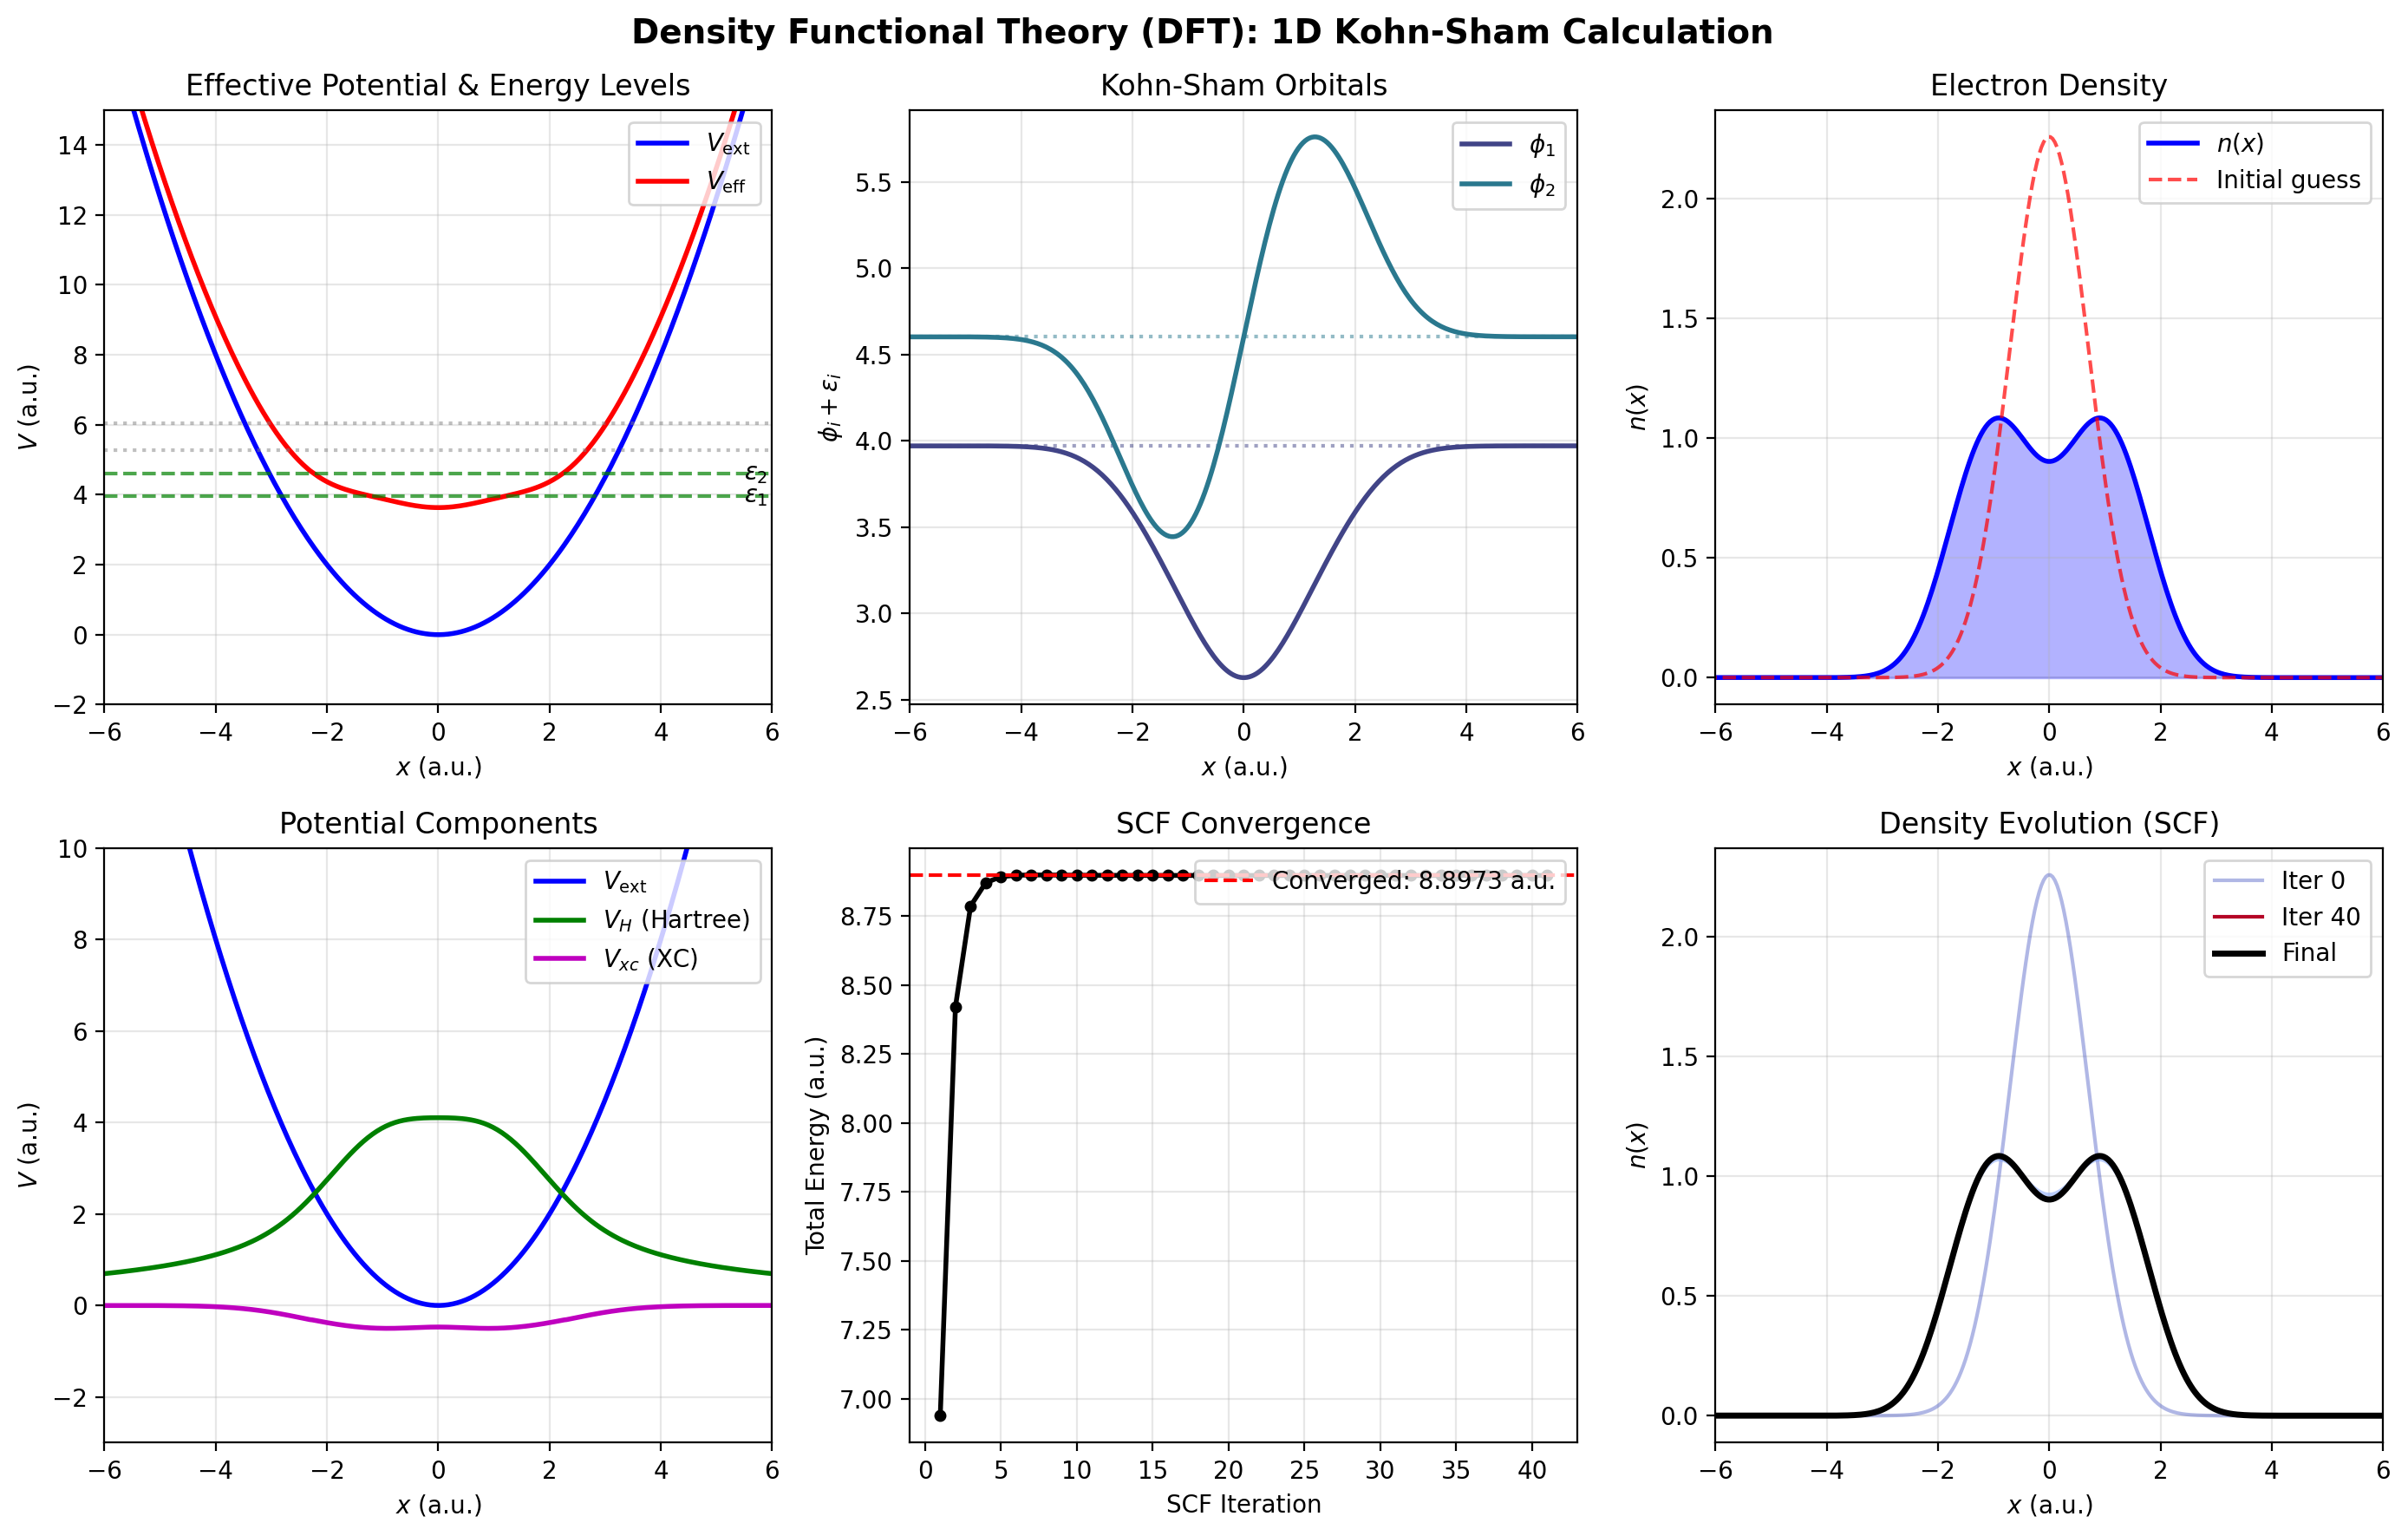


Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle('Density Functional Theory (DFT): 1D Kohn-Sham Calculation', 
             fontsize=14, fontweight='bold')

# Color scheme
colors = plt.cm.viridis(np.linspace(0.2, 0.8, N_occupied + 2))

# Plot 1: Effective potential and energy levels
ax1 = axes[0, 0]
ax1.plot(x, results['V_ext'], 'b-', lw=2, label=r'$V_{\rm ext}$')
ax1.plot(x, results['V_eff'], 'r-', lw=2, label=r'$V_{\rm eff}$')
ax1.set_xlim(-6, 6)
ax1.set_ylim(-2, 15)

# Add energy levels
for i in range(N_occupied + 2):
    if i < N_occupied:
        ax1.axhline(results['eigenvalues'][i], color='green', ls='--', alpha=0.7)
        ax1.text(5.5, results['eigenvalues'][i], f'$\\varepsilon_{i+1}$', 
                fontsize=10, va='center')
    else:
        ax1.axhline(results['eigenvalues'][i], color='gray', ls=':', alpha=0.5)

ax1.set_xlabel(r'$x$ (a.u.)')
ax1.set_ylabel(r'$V$ (a.u.)')
ax1.set_title('Effective Potential & Energy Levels')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Kohn-Sham orbitals
ax2 = axes[0, 1]
for i in range(N_occupied):
    # Offset orbitals by their eigenvalues for visualization
    orbital = results['eigenvectors'][:, i]
    ax2.plot(x, orbital * 2 + results['eigenvalues'][i], 
            color=colors[i], lw=2, label=f'$\\phi_{i+1}$')
    ax2.axhline(results['eigenvalues'][i], color=colors[i], ls=':', alpha=0.5)

ax2.set_xlim(-6, 6)
ax2.set_xlabel(r'$x$ (a.u.)')
ax2.set_ylabel(r'$\phi_i + \varepsilon_i$')
ax2.set_title('Kohn-Sham Orbitals')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Electron density
ax3 = axes[0, 2]
ax3.fill_between(x, results['density'], alpha=0.3, color='blue')
ax3.plot(x, results['density'], 'b-', lw=2, label=r'$n(x)$')

# Compare with non-interacting density (initial guess scaled)
n_initial = N_electrons * np.exp(-x**2) / np.sqrt(np.pi)
n_initial = n_initial * N_electrons / simpson(n_initial, x=x)
ax3.plot(x, n_initial, 'r--', lw=1.5, label='Initial guess', alpha=0.7)

ax3.set_xlim(-6, 6)
ax3.set_xlabel(r'$x$ (a.u.)')
ax3.set_ylabel(r'$n(x)$')
ax3.set_title('Electron Density')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Plot 4: Potential components
ax4 = axes[1, 0]
ax4.plot(x, results['V_ext'], 'b-', lw=2, label=r'$V_{\rm ext}$')
ax4.plot(x, results['V_H'], 'g-', lw=2, label=r'$V_H$ (Hartree)')
ax4.plot(x, results['V_xc'], 'm-', lw=2, label=r'$V_{xc}$ (XC)')
ax4.set_xlim(-6, 6)
ax4.set_ylim(-3, 10)
ax4.set_xlabel(r'$x$ (a.u.)')
ax4.set_ylabel(r'$V$ (a.u.)')
ax4.set_title('Potential Components')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Plot 5: SCF convergence
ax5 = axes[1, 1]
iterations = np.arange(1, len(results['energies']) + 1)
ax5.plot(iterations, results['energies'], 'ko-', lw=2, markersize=4)
ax5.axhline(results['energies'][-1], color='red', ls='--', 
           label=f'Converged: {results["energies"][-1]:.4f} a.u.')
ax5.set_xlabel('SCF Iteration')
ax5.set_ylabel('Total Energy (a.u.)')
ax5.set_title('SCF Convergence')
ax5.legend(loc='upper right')
ax5.grid(True, alpha=0.3)

# Plot 6: Density evolution during SCF
ax6 = axes[1, 2]
n_snapshots = min(6, len(results['density_history']))
indices = np.linspace(0, len(results['density_history'])-1, n_snapshots, dtype=int)
cmap = plt.cm.coolwarm

for idx, i in enumerate(indices):
    alpha = 0.4 + 0.6 * idx / (n_snapshots - 1)
    color = cmap(idx / (n_snapshots - 1))
    label = f'Iter {i}' if idx in [0, n_snapshots-1] else None
    ax6.plot(x, results['density_history'][i], color=color, 
            alpha=alpha, lw=1.5, label=label)

ax6.plot(x, results['density'], 'k-', lw=2.5, label='Final')
ax6.set_xlim(-6, 6)
ax6.set_xlabel(r'$x$ (a.u.)')
ax6.set_ylabel(r'$n(x)$')
ax6.set_title('Density Evolution (SCF)')
ax6.legend(loc='upper right')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('density_functional_theory_dft_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Discussion and Physical Interpretation

### Results Summary

Our 1D Kohn-Sham DFT calculation demonstrates several key features of the method:

1. **Self-Consistency**: The SCF procedure converges as the electron density and effective potential reach mutual consistency. The energy decreases monotonically toward the ground state.

2. **Effective Potential**: The total effective potential $V_{\text{eff}} = V_{\text{ext}} + V_H + V_{xc}$ includes:
   - The external harmonic confinement
   - The repulsive Hartree potential from electron-electron electrostatics
   - The attractive exchange-correlation potential that partially cancels Hartree repulsion

3. **Kohn-Sham Orbitals**: The single-particle orbitals $\phi_i$ are *not* true electron wavefunctions, but auxiliary functions whose squares sum to the exact density. Nevertheless, their eigenvalues provide useful approximations to ionization potentials and electron affinities.

4. **HOMO-LUMO Gap**: In exact DFT, the Kohn-Sham gap underestimates the true fundamental gap. Our simplified 1D model shows this qualitatively.

### Limitations of This Model

- **1D Approximation**: Real systems are 3D; the 1D model captures qualitative physics but not quantitative accuracy.
- **Simplified XC Functional**: The LDA is the simplest approximation. Modern calculations use GGA (Generalized Gradient Approximation), meta-GGA, or hybrid functionals.
- **Soft Coulomb Interaction**: We used a softened electron-electron interaction to avoid numerical singularities.

### Extensions

Real DFT codes implement:
- Periodic boundary conditions for solids
- Pseudopotentials for efficient core electron treatment
- Plane-wave or localized basis sets
- Spin-polarized calculations for magnetic systems
- Time-dependent DFT (TDDFT) for excited states

## Conclusion

Density Functional Theory provides a practical route to quantum mechanical calculations for many-electron systems. By reformulating the problem in terms of electron density and introducing the Kohn-Sham auxiliary system, DFT achieves a favorable balance between accuracy and computational cost. Our pedagogical 1D implementation illustrates the essential SCF procedure at the heart of all DFT calculations, demonstrating how the interplay between kinetic energy, external potential, Hartree repulsion, and exchange-correlation effects determines the ground-state electronic structure.